In [1]:
import os

In [2]:
base_path = "flofrumush"

In [3]:
train_dir = base_path + "/train"
valid_dir = base_path + "/valid"
test_dir = base_path + "/test"

In [4]:
flower_train = os.listdir(train_dir + "/flower")
fruit_train = os.listdir(train_dir + "/fruit")
mush_train = os.listdir(train_dir + "/mushroom")

In [5]:
flower_valid = os.listdir(valid_dir + "/flower")
fruit_valid = os.listdir(valid_dir + "/fruit")
mush_valid = os.listdir(valid_dir + "/mushroom")

In [6]:
flower_test = os.listdir(test_dir + "/flower")
fruit_test = os.listdir(test_dir + "/fruit")
mush_test = os.listdir(test_dir + "/mushroom")

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

2023-05-07 03:57:42.738633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import numpy as np

In [9]:
batch_size = 12
img_height = 256
img_width = 256

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, labels="inferred",image_size=(img_height, img_width),batch_size=batch_size)
val_data = tf.keras.utils.image_dataset_from_directory(valid_dir, labels="inferred",image_size=(img_height, img_width),batch_size=batch_size)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, labels="inferred",image_size=(img_height, img_width))

Found 458 files belonging to 3 classes.
Found 129 files belonging to 3 classes.
Found 67 files belonging to 3 classes.


In [11]:
class_names = train_data.class_names
print(class_names)

['flower', 'fruit', 'mushroom']


2023-05-07 03:57:46.193847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 03:57:46.194213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [458]
	 [[{{node Placeholder/_0}}]]


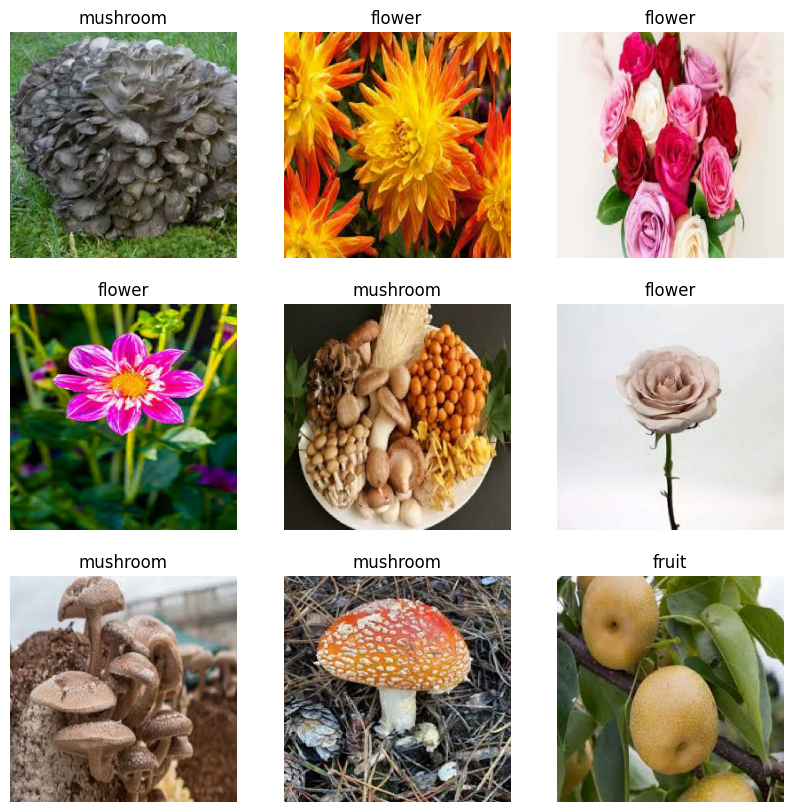

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in test_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


2023-05-07 03:57:47.386537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [67]
	 [[{{node Placeholder/_4}}]]
2023-05-07 03:57:47.386883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [67]
	 [[{{node Placeholder/_4}}]]


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


2023-05-07 03:57:47.603686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 03:57:47.604049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 03:57:47.713686: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipelin

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.5),
  ]
)

In [18]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath="models/",
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=20
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/20


2023-05-07 03:57:48.223645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 03:57:48.224114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [458]
	 [[{{node Placeholder/_0}}]]


39/39 [==============================] - ETA: 0s - loss: 1.4320 - accuracy: 0.4083

2023-05-07 03:58:02.445439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [129]
	 [[{{node Placeholder/_0}}]]
2023-05-07 03:58:02.445974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [129]
	 [[{{node Placeholder/_0}}]]



Epoch 1: saving model to models/
39/39 [==============================] - 15s 361ms/step - loss: 1.4320 - accuracy: 0.4083 - val_loss: 1.0157 - val_accuracy: 0.4264
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.5284
Epoch 2: saving model to models/
39/39 [==============================] - 13s 340ms/step - loss: 0.9733 - accuracy: 0.5284 - val_loss: 1.0843 - val_accuracy: 0.4651
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.5349
Epoch 3: saving model to models/
39/39 [==============================] - 13s 341ms/step - loss: 0.9617 - accuracy: 0.5349 - val_loss: 0.9996 - val_accuracy: 0.5581
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.9063 - accuracy: 0.6266
Epoch 4: saving model to models/
39/39 [==============================] - 13s 346ms/step - loss: 0.9063 - accuracy: 0.6266 - val_loss: 0.8465 - val_accuracy: 0.5659
Epoch 5/20
39/39 [==============================] - ETA: 

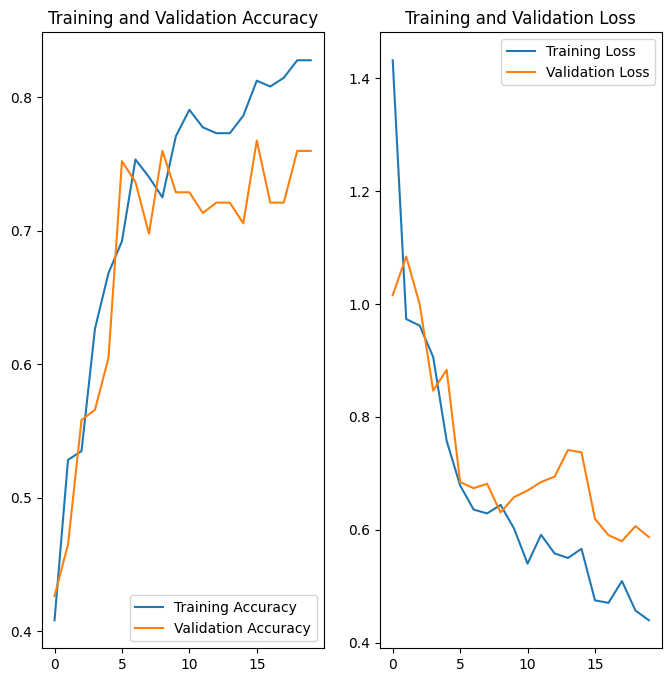

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('traning_val_acc_loss.png')
plt.show()

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [24]:
results = model.evaluate(test_data)
print("test loss:", results[0], "test acc:", results[1])

2023-05-07 04:02:21.813716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [67]
	 [[{{node Placeholder/_0}}]]
2023-05-07 04:02:21.814092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [67]
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 0s 94ms/step - loss: 0.4147 - accuracy: 0.8209
test loss: 0.41474565863609314 test acc: 0.8208954930305481


3/3 [==============================] - 0s 91ms/step


array([[ 3.2489109e+00, -2.5392547e+00, -3.2598395e+00],
       [-9.5520601e-02,  2.0337958e+00, -1.0799148e+00],
       [-3.8133130e+00,  4.0211334e+00,  1.4862022e+00],
       [ 4.2686925e+00,  1.3160230e+00, -4.0003266e+00],
       [ 8.3402795e-01,  2.9688823e+00, -1.6046247e+00],
       [ 7.1032715e+00, -4.9565277e+00, -4.5145130e+00],
       [ 1.4428188e+00,  1.9913759e+00, -1.4099387e+00],
       [-3.1824186e+00, -3.0110066e+00,  3.6561890e+00],
       [ 2.1511166e+00, -4.1618454e-01, -1.9982322e+00],
       [ 8.6520118e-01,  2.9851153e+00, -2.6122613e+00],
       [-2.1703374e+00, -2.6636264e+00,  2.5001810e+00],
       [ 4.5232546e-01,  4.4985390e+00, -1.3937345e+00],
       [ 2.7201009e+00, -4.5151949e+00, -1.5567266e+00],
       [ 3.1519771e-01, -1.3555662e-01,  2.7918714e-01],
       [ 1.0473409e+00,  7.8378952e-01, -1.0716728e+00],
       [ 7.7690272e+00, -3.5849696e-01, -7.6030412e+00],
       [-2.3345120e+00,  2.9791442e-01,  2.0350089e+00],
       [-1.9031543e+00,  3.7052